**Importing Necessary Libraries**

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

#Setting display options for better visualization
pd.set_option('display.max_columns',None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*50)
print("TELECOM CUSTOMER CHURN PREDICTION")
print("="*50)
print("Created by:[Ayush Singh]")
print("="*50)


TELECOM CUSTOMER CHURN PREDICTION
Created by:[Ayush Singh]


**Data Loading & Initial Exploration**

In [58]:
#Loading the dataset
df = pd.read_csv('https://raw.githubusercontent.com/ayushbora2003/Telecom_Customer_Churn_Prediction/main/data/Data_file.csv')



In [59]:
#Basic Information
print(f"\nDataset Shape:{df.shape}")
print(f"Total Records:{df.shape[0]}")
print(f"Total Features:{df.shape[1]}")

#Displaying first few rows
df.head()
#Checking data types
df.dtypes


Dataset Shape:(7043, 21)
Total Records:7043
Total Features:21


,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


**Data Cleaning and Preprocessing**

In [60]:
#Checking for missing values
missing_values=df.isnull().sum()
print(missing_values[missing_values>0])

TotalCharges    11
dtype: int64


In [61]:
#Handling missing values in TotalCharges
if'TotalCharges' in df.columns:
  #converting TotalCharges to numeric, coerce errors to NaN
  df['TotalCharges']=pd.to_numeric(df['TotalCharges'], errors='coerce')

  # Checking how many missing values
  missing_total=df['TotalCharges'].isnull().sum()
  print(f"\n Missing values in TotalCharges:{missing_total}")

  #Filling missing values with 0(assuming new customers)
  df['TotalCharges'].fillna(0,inplace=True)
  print("Missing values in TotalCharges filled with 0")

  # Also checking for empty strings that might represent missing values
  # Converting any empty strings or whitespace to NaN for other columns
  df=df.replace(r'^\s*$',np.nan, regex=True)

  #Filling other categorical missing values with 'unknown'
  categorical_cols=df.select_dtypes(include=['object']).columns
  for col in categorical_cols:
    if df[col].isnull().any():
      df[col].fillna('unknown',inplace=True)
      print(f"Missing values in {col}filled with'unknown'")

  #Removing customerID as it's not useful for prediction
  if 'customerID' in df.columns:
    df=df.drop('customerID',axis=1)
    print("Removed customerID column (unique identifier)")

  #Cheking the cleaned dataset
  print(f"\n Dataset after cleaning:")
  print(f"shape{df.shape}")
  print(f"Remaining missing values:{df.isnull().sum()}")



 Missing values in TotalCharges:11
Missing values in TotalCharges filled with 0
Removed customerID column (unique identifier)

 Dataset after cleaning:
shape(7043, 20)
Remaining missing values:gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


**Exploratory Data Analysis(EDA)**


Target Variable Analysis(churn)


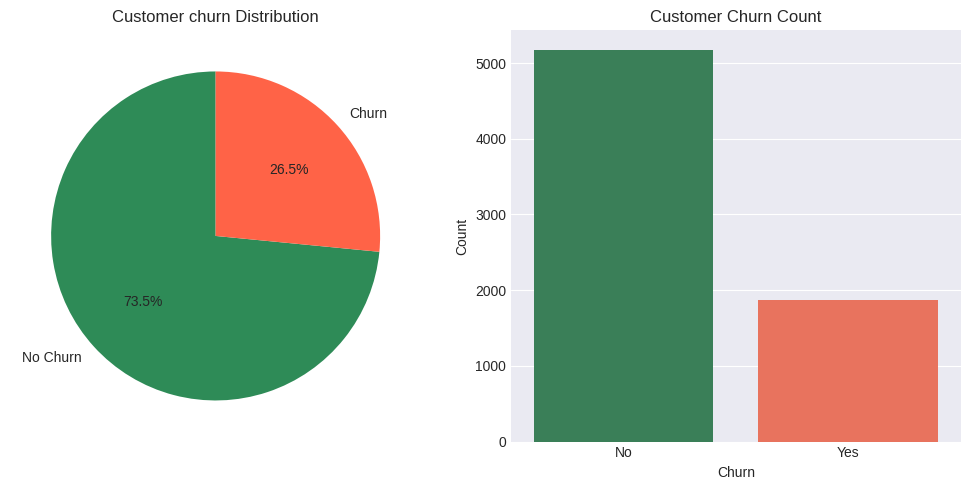


 Churn Rate:26.54%
 Non-Churn Rate:73.46%


In [62]:
#Target variable analysis
print("\nTarget Variable Analysis(churn)")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
churn_counts=df['Churn'].value_counts()
colors=['#2E8B57','#FF6347']
plt.pie(churn_counts.values, labels=['No Churn','Churn'],autopct='%1.1f%%', colors=colors,startangle=90)
plt.title('Customer churn Distribution')

plt.subplot(1,2,2)
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette=colors)
plt.title('Customer Churn Count')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('churn_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


churn_rate=df['Churn'].value_counts(normalize=True)['Yes']*100
print(f"\n Churn Rate:{churn_rate:.2f}%")
print(f" Non-Churn Rate:{100-churn_rate:.2f}%")


Numerical columns:['tenure', 'MonthlyCharges', 'TotalCharges']


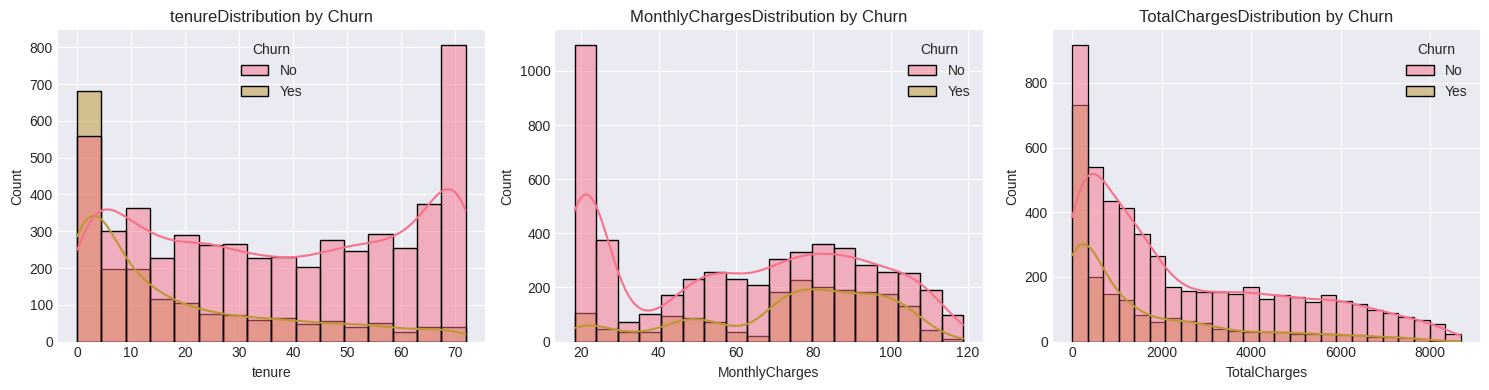

In [63]:
# Numerical Features Analysis

numerical_cols=['tenure', 'MonthlyCharges','TotalCharges']
print(f"Numerical columns:{numerical_cols}")

fig, axes=plt.subplots(1, 3, figsize=(15,4))
for idx, col in enumerate(numerical_cols):
  sns.histplot(data=df, x=col, hue='Churn', kde=True, ax=axes[idx])
  axes[idx].set_title(f'{col}Distribution by Churn')
  axes[idx].set_xlabel(col)
plt.tight_layout()
plt.savefig('numerical_features.png',dpi=300, bbox_inches='tight')
plt.show()



In [64]:
#Statistical summary
print("\n Statistical Summary of Numerical Features:")
print(df[numerical_cols].describe())



 Statistical Summary of Numerical Features:
            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2279.734304
std      24.559481       30.090047   2266.794470
min       0.000000       18.250000      0.000000
25%       9.000000       35.500000    398.550000
50%      29.000000       70.350000   1394.550000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000


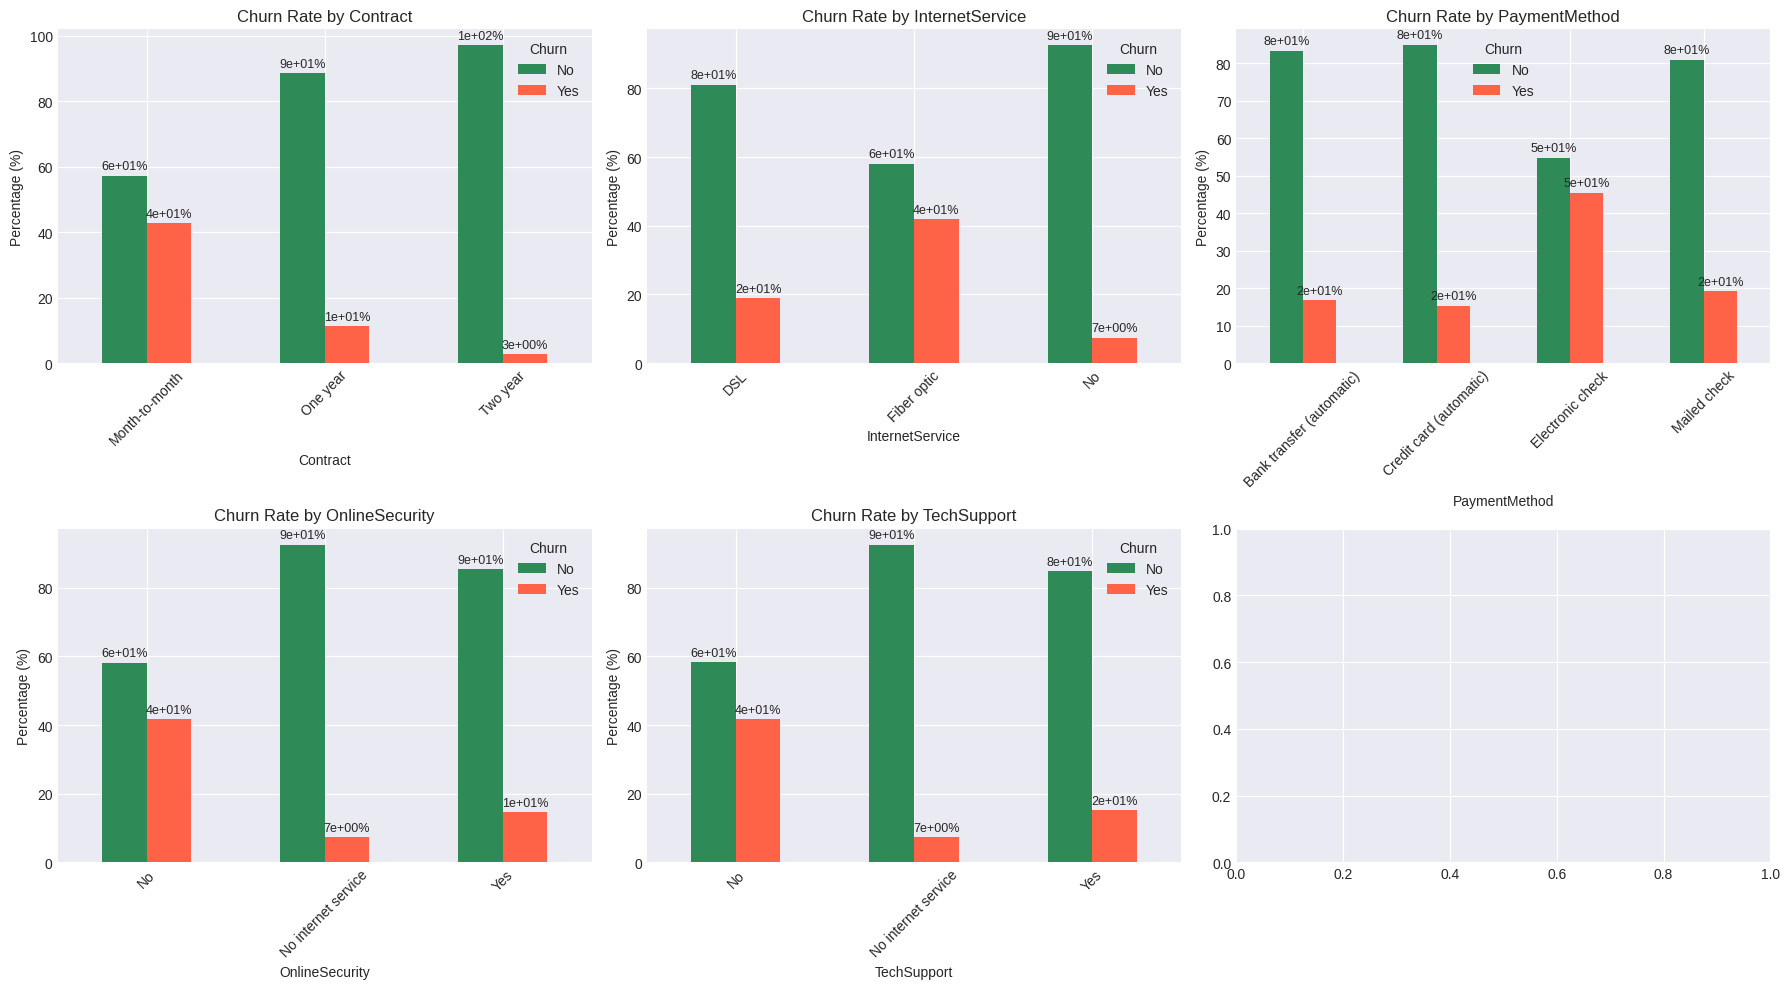


CORRELATION ANALYSIS


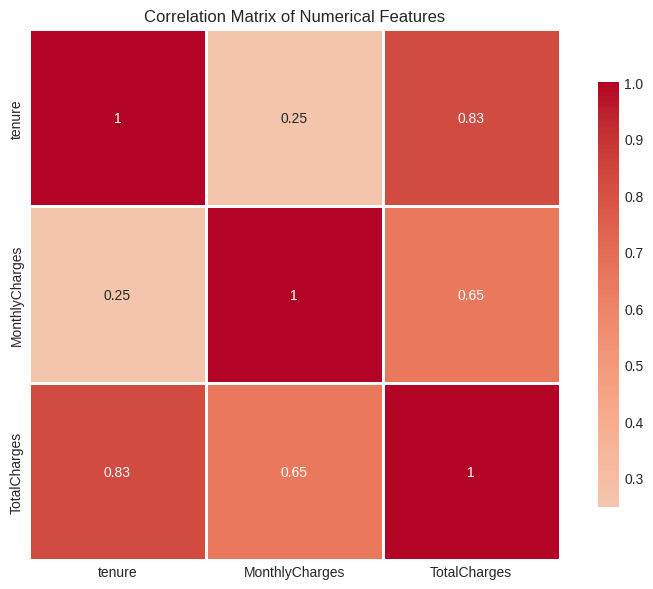


Correlation with Churn (encoded):
Churn_encoded     1.000000
MonthlyCharges    0.193356
TotalCharges     -0.198324
tenure           -0.352229
Name: Churn_encoded, dtype: float64


In [65]:
#Categorical Features Analysis
categorical_cols=['gender','SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

#Converting SeniorCitizen to categorical for better visualization
df['SeniorCitizen']=df['SeniorCitizen'].map({0:'No',1:'Yes'})

#Analyzing top 5 important categorical features
important_cats=['Contract', 'InternetService', 'PaymentMethod', 'OnlineSecurity', 'TechSupport']

fig, axes=plt.subplots(2, 3, figsize=(18, 10))
axes=axes.flatten()

for idx, col in enumerate(important_cats[:6]):
  #Creating crosstab
  ct=pd.crosstab(df[col], df['Churn'], normalize='index')*100
  ct.plot(kind='bar', ax=axes[idx], color=['#2E8B57', '#FF6347'])
  axes[idx].set_title(f'Churn Rate by {col}')
  axes[idx].set_xlabel(col)
  axes[idx].set_ylabel('Percentage (%)')
  axes[idx].legend(title='Churn')
  axes[idx].tick_params(axis='x', rotation=45)
  #adding percentage labels
  for p in axes[idx].patches:
    height=p.get_height()
    axes[idx].text(p.get_x()+p.get_width()/2., height+1, f'{height:.1}%',ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('categorical_features.png',dpi=300, bbox_inches='tight')
plt.show()

#Correlation Analysis
print("\nCORRELATION ANALYSIS")

#Creating correlation matrix for numerical features
corr_matrix=df[numerical_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, linewidths=1, cbar_kws={"shrink":0.8})
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCorrelation with Churn (encoded):")
#Encoding churn for correlation
df_corr=df.copy()
df_corr['Churn_encoded']=df_corr['Churn'].map({'No':0,'Yes':1})
correlation_with_churn=df_corr[numerical_cols+['Churn_encoded']].corr()['Churn_encoded'].sort_values(ascending=False)
print(correlation_with_churn)

**Fearture Engineering**

In [66]:
#Creating a Copy of feature engineering
df_encoded=df.copy()

# Convert 'SeniorCitizen' back to integer type (0 or 1) from 'No'/'Yes' strings
# if it was converted in EDA for visualization. This ensures it's treated as a numerical feature
# and will not be passed to the LabelEncoder for categorical columns.
if df_encoded['SeniorCitizen'].dtype == 'object':
    df_encoded['SeniorCitizen'] = df_encoded['SeniorCitizen'].map({'No': 0, 'Yes': 1}).astype(int)

#Encoding categorical variables
print("\nEncoding Categorical Variables")

#List of categorical columns to encode
categorical_cols=df_encoded.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('Churn')#We'll handle target separately

# Ensure SeniorCitizen is not in categorical_cols if it was meant to be numerical
# (this check might be redundant if the above conversion works, but adds robustness)
if 'SeniorCitizen' in categorical_cols:
    categorical_cols.remove('SeniorCitizen')

print(f"Categorical columns to encode:{categorical_cols}")

#Applying Label Encoding
label_encoders={}
for col in categorical_cols:
  le=LabelEncoder()
  df_encoded[col]=le.fit_transform(df_encoded[col])
  label_encoders[col]=le
  print(f"Encoded:{col}")

#Encoding target variable
df_encoded['Churn']=df_encoded['Churn'].map({'No':0,'Yes':1})

#Feature Scaling
print("\n FEATURE SCALING")

#Separating features and target
X=df_encoded.drop('Churn', axis=1)
y=df_encoded['Churn']

#Scaling numericall features
scaler=StandardScaler()
numerical_cols_for_scaling=['tenure','MonthlyCharges','TotalCharges']
X[numerical_cols_for_scaling]=scaler.fit_transform(X[numerical_cols_for_scaling])

print(f"Features scaled:{numerical_cols_for_scaling}")
print(f"Final dataset shape:{X.shape}")
print(f"Target variable shape:{y.shape}")


Encoding Categorical Variables
Categorical columns to encode:['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Encoded:gender
Encoded:Partner
Encoded:Dependents
Encoded:PhoneService
Encoded:MultipleLines
Encoded:InternetService
Encoded:OnlineSecurity
Encoded:OnlineBackup
Encoded:DeviceProtection
Encoded:TechSupport
Encoded:StreamingTV
Encoded:StreamingMovies
Encoded:Contract
Encoded:PaperlessBilling
Encoded:PaymentMethod

 FEATURE SCALING
Features scaled:['tenure', 'MonthlyCharges', 'TotalCharges']
Final dataset shape:(7043, 19)
Target variable shape:(7043,)


**Data Splitting**

In [67]:
#Splitting data into training and testing sets
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set size:{X_train.shape}")
print(f"Testing set size:{X_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Testing target distribution:\n{y_test.value_counts(normalize=True)}")

Training set size:(4930, 19)
Testing set size:(2113, 19)
Training target distribution:
Churn
0    0.734686
1    0.265314
Name: proportion, dtype: float64
Testing target distribution:
Churn
0    0.734501
1    0.265499
Name: proportion, dtype: float64


**Model Building**

In [68]:
print("\nModel Building")
#Dictionary to store model results
model_results={}

#Logistic Regression (Simple & Interpretable)
print("\nMODEL1:LOGISTIC REGRESSION")

lr_model=LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr=lr_model.predict((X_test))
y_pred_proba_lr=lr_model.predict_proba(X_test)[:,1]

#Calculating metrics
accuracy_lr=accuracy_score (y_test, y_pred_lr)
precision_lr=precision_score(y_test, y_pred_lr)
recall_lr=recall_score(y_test, y_pred_lr)
f1_lr=f1_score(y_test, y_pred_lr)
roc_auc_lr=roc_auc_score(y_test, y_pred_proba_lr)

model_results['Logistic Regession']={
    'Accuracy':accuracy_lr,
    'Precision':precision_lr,
    'Recall':recall_lr,
    'F1-Score':f1_lr,
    'ROC-AUC':roc_auc_lr
}

print(f"Accuracy:{accuracy_lr:.4f}")
print(f"Precision:{precision_lr:.4f}")
print(f"Recall:{recall_lr:.4f}")
print(f"F1-Score:{f1_lr:.4f}")
print(f"ROC-AUC:{roc_auc_lr:.4f}")




Model Building

MODEL1:LOGISTIC REGRESSION
Accuracy:0.8036
Precision:0.6496
Recall:0.5651
F1-Score:0.6044
ROC-AUC:0.8428


In [69]:
#Decision Tree
print("\nDecision Tree Classifier")

dt_model=DecisionTreeClassifier(random_state=42, max_depth=5)
dt_model.fit(X_train, y_train)
y_pred_dt=dt_model.predict(X_test)
y_pred_proba_dt=dt_model.predict_proba(X_test)[:,1]

#Calculating metrics
accuracy_dt=accuracy_score(y_test, y_pred_dt)
precision_dt=precision_score(y_test, y_pred_dt)
recall_dt=recall_score(y_test, y_pred_dt)
f1_dt=f1_score(y_test, y_pred_dt)
roc_auc_dt=roc_auc_score(y_test, y_pred_proba_dt)

model_results['Decision Tree']={
    'Accuracy':accuracy_dt,
    'Precision':precision_dt,
    'Recall':recall_dt,
    'F1-Score':f1_dt,
    'ROC-AUC':roc_auc_dt
}

print(f"Accuracy:{accuracy_dt:.4f}")
print(f"Precisin:{precision_dt:.4f}")
print(f"Recall:{recall_dt:.4f}")
print(f"F1-Score:{f1_dt}")
print(f"ROC-AUC:{roc_auc_dt:.4f}")



Decision Tree Classifier
Accuracy:0.7866
Precisin:0.5996
Recall:0.5900
F1-Score:0.5947888589398024
ROC-AUC:0.8263


In [70]:
#K-Nearest Neighbors (Distance-Based)
print("\nMODEL 3:K-NEAREST NEIGHBORS")

knn_model=KNeighborsClassifier(n_neighbors=5, weights='distance',metric='minkowski')
knn_model.fit(X_train, y_train)
y_pred_knn=knn_model.predict(X_test)
y_pred_proba_knn=knn_model.predict_proba(X_test)[:,1]

#Calculating metrics
accuracy_knn=accuracy_score(y_test, y_pred_knn)
precision_knn=precision_score(y_test, y_pred_knn)
recall_knn=recall_score(y_test,y_pred_knn)
f1_knn=f1_score(y_test, y_pred_knn)
roc_auc_knn=roc_auc_score(y_test, y_pred_proba_knn)

model_results['K-Nearest Neighbors']={
    'Accuracy':accuracy_knn,
    'Precision':precision_knn,
    'Recall':recall_knn,
    'F1-Score':f1_knn,
    'ROC-AUC':roc_auc_knn

}

print(f"Accuracy:{accuracy_knn:.4f}")
print(f"Precision:{precision_knn:.4f}")
print(f"Recall:{recall_knn}")
print(f"F1-Score:{f1_knn:.4f}")
print(f"ROC-AUC{roc_auc_knn:.4f}")



MODEL 3:K-NEAREST NEIGHBORS
Accuracy:0.7567
Precision:0.5439
Recall:0.5187165775401069
F1-Score:0.5310
ROC-AUC0.7638


**Model Evaluation and Comparison**


Model Performance Comparison
                     Accuracy  Precision    Recall  F1-Score   ROC-AUC
Logistic Regession   0.803597   0.649590  0.565062  0.604385  0.842809
Decision Tree        0.786559   0.599638  0.590018  0.594789  0.826285
K-Nearest Neighbors  0.756744   0.543925  0.518717  0.531022  0.763844


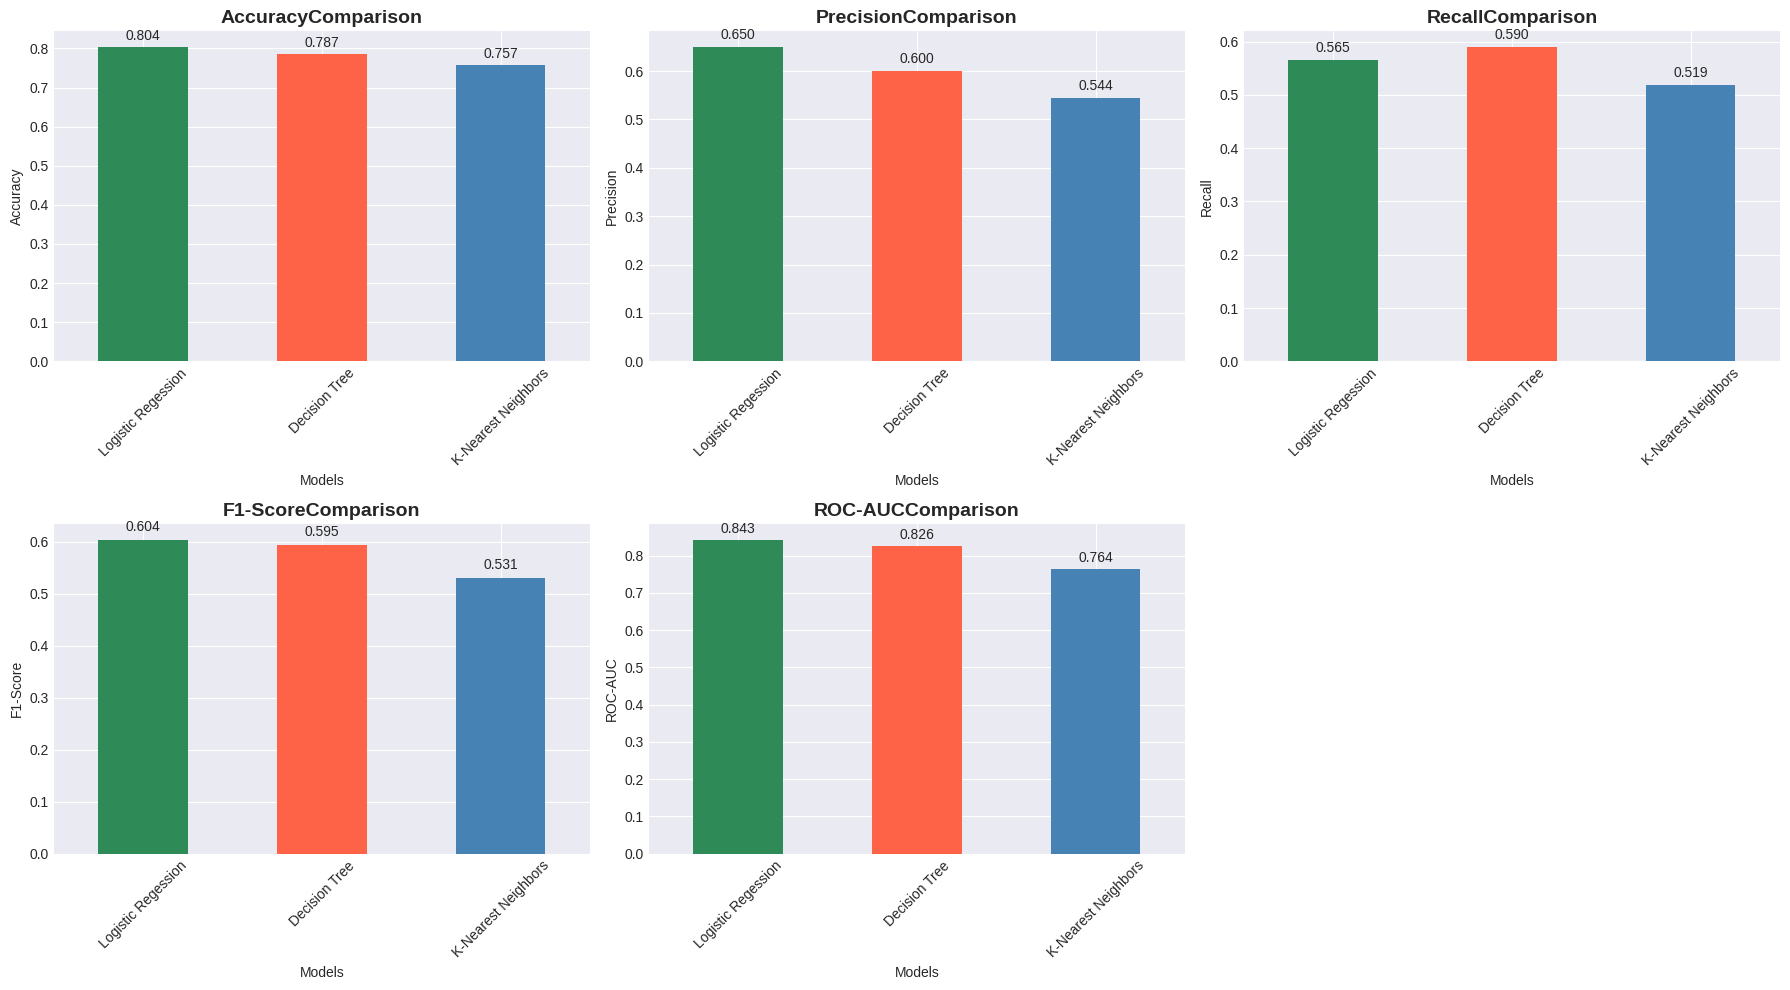


CONFUSION MATRICES


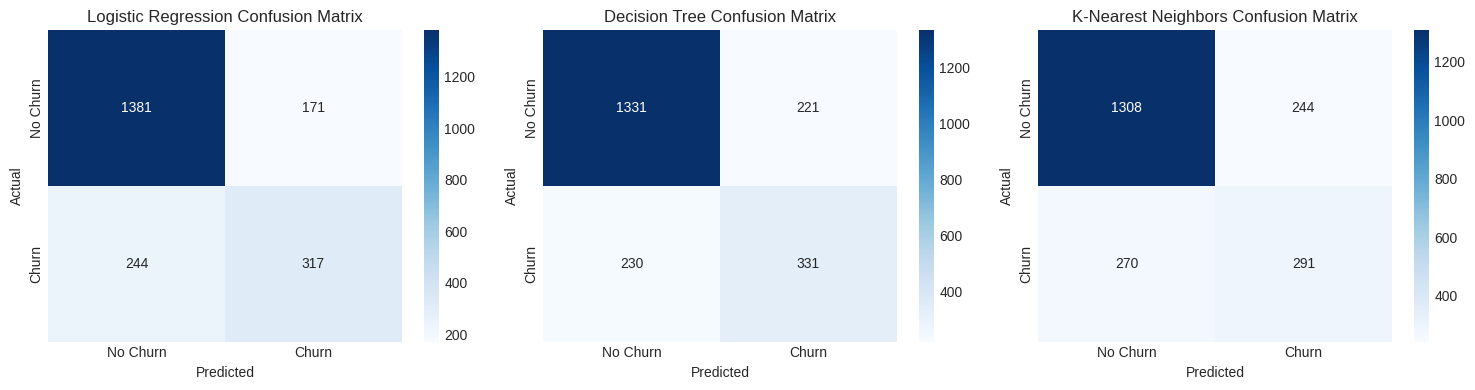


ROC CURVES


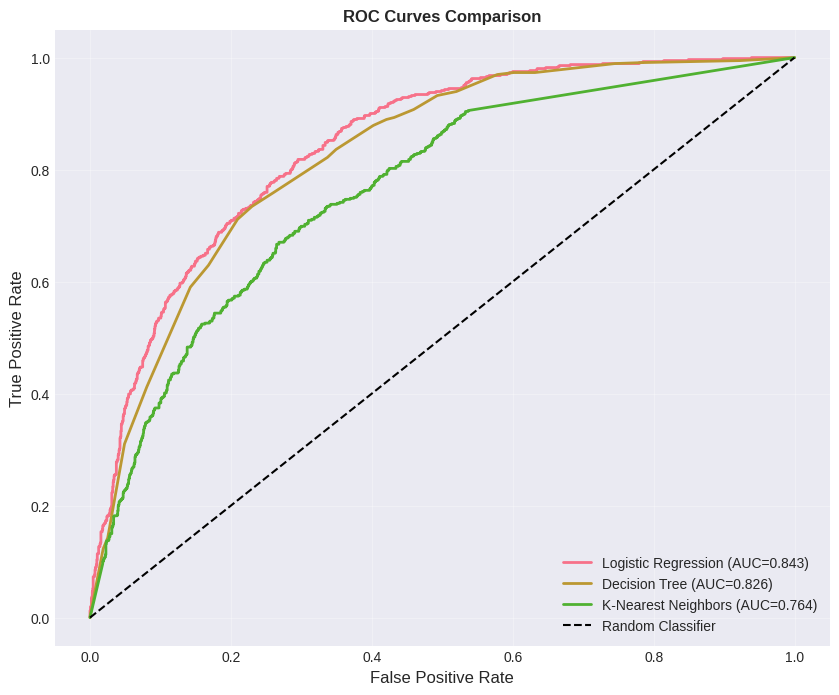


Detailed Classification Reports

LOGISTIC REGRESSION:
              precision    recall  f1-score   support

    No Churn       0.85      0.89      0.87      1552
       Churn       0.65      0.57      0.60       561

    accuracy                           0.80      2113
   macro avg       0.75      0.73      0.74      2113
weighted avg       0.80      0.80      0.80      2113


DECISION TREE:
              precision    recall  f1-score   support

    No Churn       0.85      0.86      0.86      1552
       Churn       0.60      0.59      0.59       561

    accuracy                           0.79      2113
   macro avg       0.73      0.72      0.72      2113
weighted avg       0.79      0.79      0.79      2113


K-NEAREST NEIGHBORS:
              precision    recall  f1-score   support

    No Churn       0.83      0.84      0.84      1552
       Churn       0.54      0.52      0.53       561

    accuracy                           0.76      2113
   macro avg       0.69      0.68  

In [71]:
#Comparing all models
print("\nModel Performance Comparison")

results_df=pd.DataFrame(model_results).T
print(results_df)

#Visuallize model comparison
fig, axes =plt.subplots(2,3,figsize=(18,10))
axes=axes.flatten()

metrics=['Accuracy','Precision','Recall','F1-Score','ROC-AUC']
colors=['#2E8B57', '#FF6347', '#4682B4', '#FFD700']

for idx, metric in enumerate(metrics):
  ax=axes[idx]
  results_df[metric].plot(kind='bar', ax=ax, color=colors[:len(results_df)])
  ax.set_title(f'{metric}Comparison', fontsize=14, fontweight='bold')
  ax.set_xlabel('Models')
  ax.set_ylabel(metric)
  ax.tick_params(axis='x',rotation=45)

  #Adding value labels on bars
  for i, v in enumerate(results_df[metric]):
    ax.text(i, v+0.01,f'{v:.3f}',ha='center',va='bottom',fontsize=10)

#Ploting confusion matrices for each model
axes[5].axis('off')#Hiding the last subplot

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

#Confusion Matrices
print("\nCONFUSION MATRICES")

fig, axes=plt.subplots(1, 3, figsize=(15,4))
models=[('Logistic Regression', y_pred_lr),
       ('Decision Tree', y_pred_dt),
       ('K-Nearest Neighbors',y_pred_knn)]

for idx, (name, y_pred)in enumerate(models):
  cm=confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
  axes[idx].set_title(f'{name} Confusion Matrix')
  axes[idx].set_xlabel('Predicted')
  axes[idx].set_ylabel('Actual')
  axes[idx].set_xticklabels(['No Churn', 'Churn'])
  axes[idx].set_yticklabels(['No Churn','Churn'])

plt.tight_layout()
plt.savefig('confusion_matrices.png',dpi=300, bbox_inches='tight')
plt.show()

#ROC Curves
print("\nROC CURVES")
plt.figure(figsize=(10,8))

#Plot ROC for each model
y_pred_probas={
    'Logistic Regression':y_pred_proba_lr,
    'Decision Tree':y_pred_proba_dt,
    'K-Nearest Neighbors':y_pred_proba_knn
}

for model_name, y_pred_proba in y_pred_probas.items():
  fpr, tpr, _ =roc_curve(y_test, y_pred_proba)
  auc_score=roc_auc_score(y_test, y_pred_proba)
  plt.plot(fpr, tpr, label=f'{model_name} (AUC={auc_score:.3f})',linewidth=2)

plt.plot([0,1], [0,1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

#Classification Reports
print("\nDetailed Classification Reports")

print("\nLOGISTIC REGRESSION:")
print(classification_report(y_test, y_pred_lr, target_names=['No Churn', 'Churn']))

print("\nDECISION TREE:")
print(classification_report(y_test, y_pred_dt, target_names=['No Churn', 'Churn']))

print("\nK-NEAREST NEIGHBORS:")
print(classification_report(y_test, y_pred_knn, target_names=['No Churn', 'Churn']))

**Feature Importance Analysis**


Top 10 Most Important Features:
            Feature  Importance
14         Contract    0.515490
8    OnlineSecurity    0.138393
4            tenure    0.116380
7   InternetService    0.084064
17   MonthlyCharges    0.064887
18     TotalCharges    0.042226
16    PaymentMethod    0.015525
6     MultipleLines    0.010312
1     SeniorCitizen    0.007555
3        Dependents    0.002673


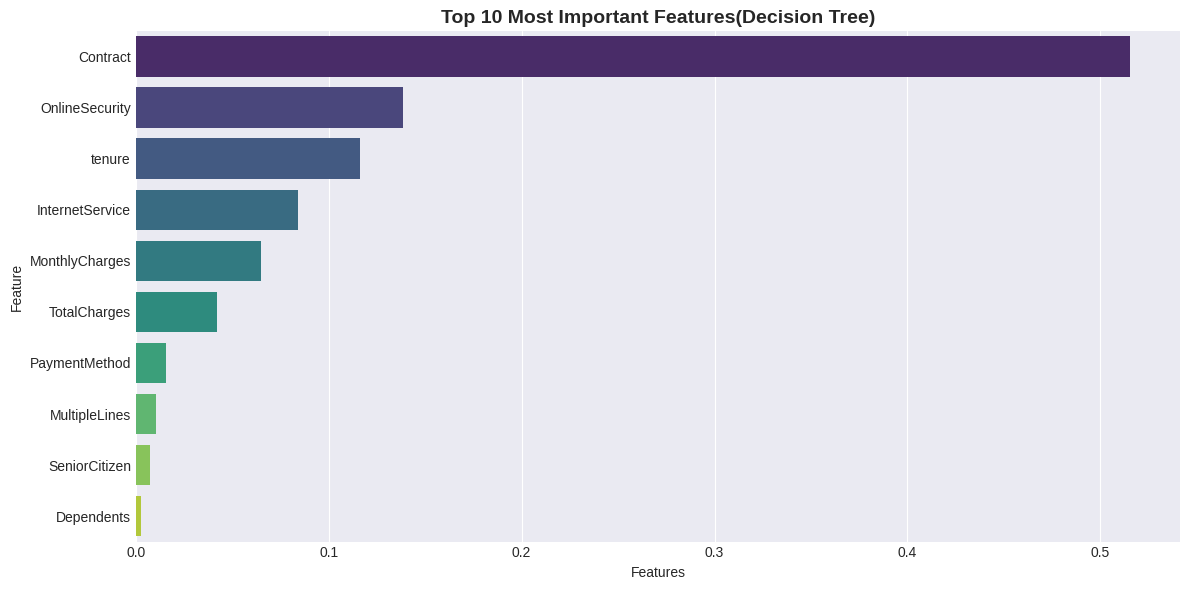

In [72]:
#Feature importance from Decision Tree
feature_importance=pd.DataFrame({
    'Feature':X.columns,
    'Importance':dt_model.feature_importances_
})
feature_importance=feature_importance.sort_values('Importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

#Visualizing feature importance
plt.figure(figsize=(12,6))
sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Most Important Features(Decision Tree)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.xlabel('Features')
plt.tight_layout()
plt.savefig('feature_importance.png',dpi=300, bbox_inches='tight')
plt.show()


In [73]:
#Business insights from importance
print("\nBUSINESS INSIGHTS FROM FEATURE IMPORTANCE:")
top_features =feature_importance.head(5)
for idx, row in top_features.iterrows():
  print(f"{row['Feature']}:Importance={row['Importance']:.3f}")

  #Adding business interpretation
  if row['Feature']=='Contract':
    print("Contract type is crucial- Longer contracts reduce churn")
  elif row['Feature']=='tenure':
    print("Tenure matters-Longer tenure customers are more loyal")
  elif row ['Feature']=='MonthlyCharges':
    print("Monthly charges affect churn- Higher charges may cause dissatisfaction")
  elif row['Feature']=='InternetService':
    print("Internet service type impacts retention")
  elif 'online' in row['Feature']:
    print(f"{row['Feature']}service influences customer satisfaction")
  print()



BUSINESS INSIGHTS FROM FEATURE IMPORTANCE:
Contract:Importance=0.515
Contract type is crucial- Longer contracts reduce churn

OnlineSecurity:Importance=0.138

tenure:Importance=0.116
Tenure matters-Longer tenure customers are more loyal

InternetService:Importance=0.084
Internet service type impacts retention

MonthlyCharges:Importance=0.065
Monthly charges affect churn- Higher charges may cause dissatisfaction



**Final Model Selection & Deployment**

In [74]:
import joblib

In [75]:
print("\n\nFINAL MODEL SELECTION")
#Selecting the best model based on F1-Score(balances precision and recall)
best_model_name=max(model_results, key=lambda x: model_results[x]['F1-Score'])
best_model_score=model_results[best_model_name]['F1-Score']

print(f"Selected Best Model:{best_model_name}")
print(f"Best F1-Score:{best_model_score:.4f}")
print(f"Accuracy:{model_results[best_model_name]['Accuracy']:.4f}")
print(f"Precision:{model_results[best_model_name]['Precision']:.4f}")
print(f"Recall:{model_results[best_model_name]['Recall']}")

#Retraining the best model on full training data
print("\nRetraining best model on full training data...")
if best_model_name=="Logistic Regression":
  final_model=LogisticRegression(random_state=42, max_iter=1000)
elif best_model_name=="Decision Tree":
  final_model=DecisionTreeClassifier(random_state=42, max_depth=5)
else:
  final_model=KNeighborsClassifier(n_neighbors=5)

final_model.fit(X_train, y_train)

#Testing final model on test set
y_pred_final=final_model.predict(X_test)
final_accuracy=accuracy_score(y_test, y_pred_final)
print(f"Final Model test accuracy:{final_accuracy:.4f}")

#Saving the final model and preprocessing objects

model_data={
    'model':final_model,
    'scaler':scaler,
    'label_encoders':label_encoders,
    'feature_names':X.columns.tolist()
 }

joblib.dump(model_data,'churn_prediction_model.pkl')
print("Model saved as 'churn_prediction_model.pkl'")





FINAL MODEL SELECTION
Selected Best Model:Logistic Regession
Best F1-Score:0.6044
Accuracy:0.8036
Precision:0.6496
Recall:0.5650623885918004

Retraining best model on full training data...
Final Model test accuracy:0.7586
Model saved as 'churn_prediction_model.pkl'


**Prediction on new Data(Demonstrtion)**

In [79]:
# ======================
# PREDICTION WITH CONFIDENCE PERCENTAGE
# ======================

print("\n" + "="*50)
print("PREDICTING ON NEW CUSTOMER")
print("="*50)

# Customer profile
customer = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 18,
    'PhoneService': 'Yes',
    'MultipleLines': 'Yes',
    'InternetService': 'DSL',
    'OnlineSecurity': 'Yes',
    'OnlineBackup': 'No',
    'DeviceProtection': 'No',
    'TechSupport': 'Yes',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'One year',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Credit card (automatic)',
    'MonthlyCharges': 70.2,
    'TotalCharges': 1263.6
}

print("\nCUSTOMER PROFILE:")
for k, v in customer.items():
    print(f"  {k}: {v}")

# Prepare data
df_customer = pd.DataFrame([customer])

# Encode categoricals
for col in label_encoders:
    if col in df_customer.columns:
        try:
            df_customer[col] = label_encoders[col].transform(df_customer[col])
        except:
            df_customer[col] = 0

# Scale numericals
df_customer[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.transform(
    df_customer[['tenure', 'MonthlyCharges', 'TotalCharges']]
)

# Predict
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

pred = model.predict(df_customer)[0]
proba = model.predict_proba(df_customer)[0]

print("\n" + "="*50)
print("PREDICTION RESULTS")
print("="*50)

churn_prob = proba[1] * 100
stay_prob = proba[0] * 100

print(f"\nPREDICTION: {'CHURN' if pred == 1 else 'NO CHURN'}")
print(f"Churn probability: {churn_prob:.1f}%")
print(f"Stay probability: {stay_prob:.1f}%")

# Calculate confidence level in percentage
confidence = abs(churn_prob - stay_prob)
print(f"Confidence level: {confidence:.1f}%")

# Describe confidence
if confidence > 60:
    print("   (Very confident prediction)")
elif confidence > 40:
    print("   (Confident prediction)")
elif confidence > 20:
    print("   (Moderate confidence)")
else:
    print("   (Low confidence - borderline case)")

print("\n" + "-"*40)
print("RISK FACTOR ANALYSIS")
print("-"*40)

risk_score = 0
positives = []
negatives = []

# Analyze each factor
if customer['Contract'] == 'Two year':
    negatives.append("Two-year contract (most secure)")
    risk_score -= 3
elif customer['Contract'] == 'One year':
    negatives.append("One-year contract (secure)")
    risk_score -= 1
else:
    positives.append("Month-to-month contract (high risk)")
    risk_score += 3

if customer['tenure'] >= 24:
    negatives.append(f"Long-term customer ({customer['tenure']} months)")
    risk_score -= 2
elif customer['tenure'] >= 12:
    negatives.append(f"Established customer ({customer['tenure']} months)")
    risk_score -= 1
else:
    positives.append(f"New customer ({customer['tenure']} months)")
    risk_score += 2

if customer['MonthlyCharges'] < 30:
    negatives.append(f"Low monthly bill (${customer['MonthlyCharges']})")
    risk_score -= 1
elif customer['MonthlyCharges'] > 80:
    positives.append(f"High monthly bill (${customer['MonthlyCharges']})")
    risk_score += 2

if customer['PaymentMethod'] == 'Electronic check':
    positives.append("Electronic check payment (high churn)")
    risk_score += 2
else:
    negatives.append(f"{customer['PaymentMethod']} payment (stable)")

# This customer has no internet service
if customer['InternetService'] == 'No':
    negatives.append("No internet service (simpler account)")
    if customer['PhoneService'] == 'Yes':
        negatives.append("Has phone service only")
    else:
        positives.append("No phone or internet (basic service)")

# Paperless billing
if customer['PaperlessBilling'] == 'Yes':
    positives.append("Paperless billing (slightly higher risk)")
    risk_score += 0.5
else:
    negatives.append("Paper billing (slightly lower risk)")

# Display factors
if positives:
    print("\nINCREASE CHURN RISK:")
    for factor in positives:
        print(f"  * {factor}")

if negatives:
    print("\nDECREASE CHURN RISK:")
    for factor in negatives:
        print(f"  * {factor}")

print(f"\nFINAL RISK SCORE: {risk_score}")
if risk_score >= 3:
    print("RISK LEVEL: HIGH - Immediate action needed")
elif risk_score >= 0:
    print("RISK LEVEL: MEDIUM - Monitor closely")
else:
    print("RISK LEVEL: LOW - Stable customer")

print("\n" + "-"*40)
print("BUSINESS RECOMMENDATIONS")
print("-"*40)

if pred == 1 or churn_prob > 40:
    print("\nACTION REQUIRED:")
    print("1. Call customer within 48 hours")
    print("2. Offer retention package")
    print("3. Check satisfaction with current service")

    if customer['Contract'] == 'Month-to-month':
        print("   - Convert to 1-year contract with 10% discount")
    if customer['PaymentMethod'] == 'Electronic check':
        print("   - Switch to auto-pay for $5 monthly credit")

elif churn_prob > 20:
    print("\nMONITORING RECOMMENDED:")
    print("1. Send satisfaction survey")
    print("2. Consider small loyalty reward")
    print("3. Check-in at contract renewal")

    if customer['InternetService'] == 'No':
        print("   - Offer internet service bundle")

else:
    print("\nSTABLE CUSTOMER:")
    print("1. Continue excellent service")
    print("2. Annual check-in")
    print("3. Consider upselling opportunities")

    if customer['InternetService'] == 'No':
        print("   - Could be opportunity for internet upsell")

# Customer value analysis
monthly_rev = customer['MonthlyCharges']
annual_value = monthly_rev * 12
print(f"\nCUSTOMER VALUE:")
print(f"   Monthly revenue: ${monthly_rev:.2f}")
print(f"   Annual value: ${annual_value:.2f}")



PREDICTING ON NEW CUSTOMER

CUSTOMER PROFILE:
  gender: Female
  SeniorCitizen: 0
  Partner: Yes
  Dependents: No
  tenure: 18
  PhoneService: Yes
  MultipleLines: Yes
  InternetService: DSL
  OnlineSecurity: Yes
  OnlineBackup: No
  DeviceProtection: No
  TechSupport: Yes
  StreamingTV: No
  StreamingMovies: No
  Contract: One year
  PaperlessBilling: Yes
  PaymentMethod: Credit card (automatic)
  MonthlyCharges: 70.2
  TotalCharges: 1263.6

PREDICTION RESULTS

PREDICTION: NO CHURN
Churn probability: 15.2%
Stay probability: 84.8%
Confidence level: 69.5%
   (Very confident prediction)

----------------------------------------
RISK FACTOR ANALYSIS
----------------------------------------

INCREASE CHURN RISK:
  * Paperless billing (slightly higher risk)

DECREASE CHURN RISK:
  * One-year contract (secure)
  * Established customer (18 months)
  * Credit card (automatic) payment (stable)

FINAL RISK SCORE: -1.5
RISK LEVEL: LOW - Stable customer

----------------------------------------
B